In [15]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def image_preprocessor(image, cell_size):
    """"
    Expects a numpy array as input image
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray_image.shape
    crop_image = gray_image[h-h//2:, ::]
    resized_image = cv2.resize(crop_image, (w//cell_size, h//cell_size), interpolation=cv2.INTER_LINEAR)
    return resized_image    

In [17]:
cell_size = 20
X_list = []
y_list = []

dataset_directory = 'dataset'
class_folders = {'strong_left':-2, 'weak_left':-1 ,'ahead':0, 'weak_right':1, 'strong_right':2}
for sub_class in class_folders:
    path = os.path.join(dataset_directory, sub_class)
    for file_name in os.listdir(path):
        if file_name.endswith('.jpg'):
            file_path = os.path.join(path, file_name)
            image =  cv2.imread(file_path, flags=cv2.IMREAD_COLOR)
            result = image_preprocessor(image, cell_size)
            X_list.append(result)
            y_list.append(class_folders[sub_class])

X = np.array(X_list)
y = np.array(y_list)

X = X.reshape(X.shape[0], 1, 24, 32)/255.0

unique_degrees = np.unique(y)  # Get all unique degrees
degree_to_class = {degree: idx for idx, degree in enumerate(unique_degrees)}  # Create a mapping

# Convert degrees to class indices
y_int = np.array([degree_to_class[degree] for degree in y])

# expand so that we have 11 onehot classess
n_values = np.max(y_int) + 1
y_copy = np.copy(y_int)
y = np.eye(n_values)[y_copy]

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, root_mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import v2
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np



In [ ]:

# Split the dataset into training and validation sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

class_labels = class_folders.values()
class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(y_int, axis=0), y=y_int)
class_weights=torch.tensor(class_weights,dtype=torch.float)

tensor_train_X = torch.tensor(X_train, dtype=torch.float32)
tensor_valid_X = torch.tensor(X_val, dtype=torch.float32)
tensor_test_X = torch.tensor(X_test, dtype=torch.float32)
tensor_train_X_full = torch.tensor(X_train_full, dtype=torch.float32)

tensor_train_y = torch.tensor(y_train, dtype=torch.float32)
tensor_valid_y = torch.tensor(y_val, dtype=torch.float32)
tensor_test_y = torch.tensor(y_test, dtype=torch.float32)
tensor_train_y_full = torch.tensor(y_train_full, dtype=torch.float32)

train_ds = TensorDataset(tensor_train_X, tensor_train_y,)
valid_ds = TensorDataset(tensor_valid_X, tensor_valid_y)
test_ds = TensorDataset(tensor_test_X, tensor_test_y)
train_full_ds = TensorDataset(tensor_train_X_full, tensor_train_y_full)



In [20]:
# Define the model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.dropout3 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(256, 128)  # Adjust dimensions according to your input size
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = y_train.shape[1]
model = CNNModel(num_classes)

train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
for X_batch, y_batch in train_loader:
    print(X_batch.shape)
    print(X_batch[0])
#

torch.Size([100, 1, 24, 32])
tensor([[[0.2000, 0.3412, 0.2078, 0.2627, 0.2980, 0.3647, 0.3843, 0.4039,
          0.4118, 0.4588, 0.5255, 0.5882, 0.7137, 0.7020, 0.6902, 0.7176,
          0.6431, 0.7843, 0.7961, 0.8549, 0.8353, 0.8196, 0.8235, 0.8118,
          0.8039, 0.8275, 0.6941, 0.6549, 0.6627, 0.6196, 0.6000, 0.5725],
         [0.1294, 0.2588, 0.4824, 0.4078, 0.4588, 0.5255, 0.6667, 0.6118,
          0.5882, 0.6157, 0.6510, 0.6549, 0.5529, 0.7882, 0.7961, 0.8235,
          0.8196, 0.8196, 0.8196, 0.7882, 0.6588, 0.8314, 0.8235, 0.8039,
          0.8039, 0.8275, 0.7176, 0.6745, 0.6706, 0.6392, 0.6235, 0.6078],
         [0.3216, 0.4824, 0.4863, 0.5490, 0.5765, 0.6196, 0.6706, 0.6510,
          0.6392, 0.6588, 0.6941, 0.7686, 0.8196, 0.3373, 0.8196, 0.8314,
          0.8275, 0.8314, 0.8314, 0.8588, 0.8549, 0.8314, 0.5373, 0.7490,
          0.8000, 0.8118, 0.7412, 0.6902, 0.6863, 0.6510, 0.6353, 0.6157],
         [0.4353, 0.5216, 0.5333, 0.5725, 0.6275, 0.6549, 0.6863, 0.6941,
      

In [21]:
# transforms
transform = v2.Compose([
    v2.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

# Prepare datasets and dataloaders
batch_size = 100
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Training loop
best_val_loss = float('inf')
checkpoint_filepath = 'best_model.pth'
history = {'loss': [], 'val_loss': []}

for epoch in range(150):  # Number of epochs
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = transform(X_batch)
        y_batch = torch.argmax(y_batch, dim=1) # dimension fuckery, needs 0 or 1 dimension for cross entropy loss
        optimizer.zero_grad()
        outputs = model(X_batch)  
        #sneaky class regression
        # loss = hybrid_loss(outputs, y_batch, class_labels)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch) 
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_filepath)
    
    print(f"Epoch {epoch+1}/{200}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch 1/200, Loss: 1.6105, Val Loss: 1.6081
Epoch 2/200, Loss: 1.6080, Val Loss: 1.6072
Epoch 3/200, Loss: 1.6078, Val Loss: 1.6062
Epoch 4/200, Loss: 1.6061, Val Loss: 1.6042
Epoch 5/200, Loss: 1.6010, Val Loss: 1.5995
Epoch 6/200, Loss: 1.5928, Val Loss: 1.5899
Epoch 7/200, Loss: 1.5764, Val Loss: 1.5633
Epoch 8/200, Loss: 1.5519, Val Loss: 1.5121
Epoch 9/200, Loss: 1.4914, Val Loss: 1.4147
Epoch 10/200, Loss: 1.4324, Val Loss: 1.2896
Epoch 11/200, Loss: 1.3115, Val Loss: 1.1451
Epoch 12/200, Loss: 1.2062, Val Loss: 1.0123
Epoch 13/200, Loss: 1.0993, Val Loss: 0.9108
Epoch 14/200, Loss: 1.0069, Val Loss: 0.8545
Epoch 15/200, Loss: 0.9435, Val Loss: 0.7721
Epoch 16/200, Loss: 0.9047, Val Loss: 0.7083
Epoch 17/200, Loss: 0.8574, Val Loss: 0.6883
Epoch 18/200, Loss: 0.7960, Val Loss: 0.5929
Epoch 19/200, Loss: 0.7606, Val Loss: 0.5686
Epoch 20/200, Loss: 0.7264, Val Loss: 0.5785
Epoch 21/200, Loss: 0.6747, Val Loss: 0.5272
Epoch 22/200, Loss: 0.6727, Val Loss: 0.5106
Epoch 23/200, Loss:

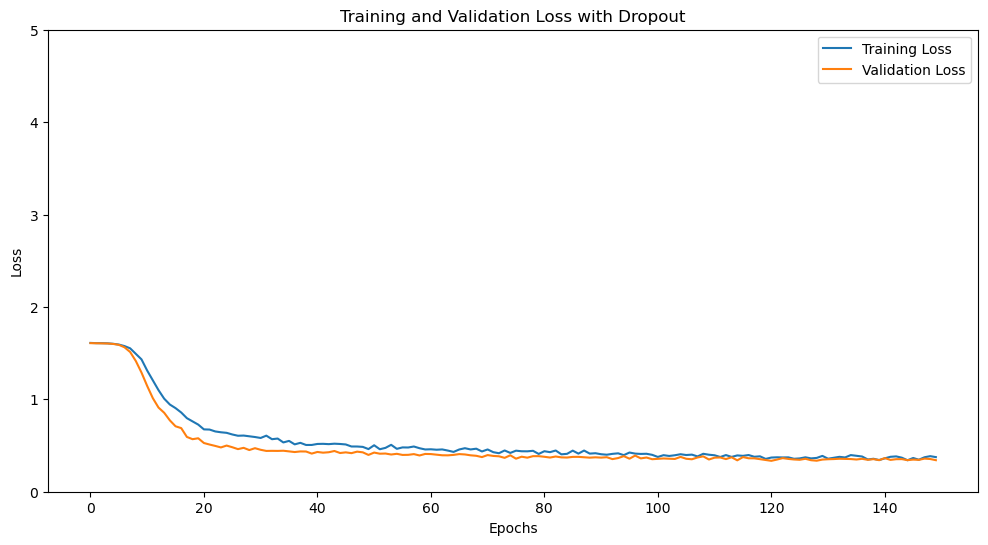

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
              precision    recall  f1-score   support

        -2.0       0.81      0.94      0.87        36
        -1.0       0.90      0.79      0.84        68
         0.0       0.74      0.82      0.78        67
         1.0       0.88      0.77      0.82        79
         2.0       0.85      0.95      0.90        43

    accuracy                           0.84       293
   macro avg       0.84      0.86      0.84       293
weighted avg       0.84      0.84      0.84       293



In [22]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 5))
plt.legend()
plt.show()

# Make predictions
model.load_state_dict(torch.load(checkpoint_filepath))
model.eval()

y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)  
        predictions = torch.argmax(outputs, dim=1)
        y_pred.extend(predictions.cpu().numpy())
y_pred = np.array(y_pred)
class_keys = list(class_folders.values())
class_keys = np.array(class_keys)
y_pred_tf = class_keys[y_pred]

print(y_test)
y_test_tf = np.dot(y_test, class_keys)

# Print classification report
print(classification_report(y_test_tf, y_pred_tf, ))

# Train on full!!!

In [10]:
num_classes = y_train.shape[1]
model = CNNModel(num_classes)

In [23]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

# Prepare datasets and dataloaders
batch_size = 100
train_loader = DataLoader(train_full_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=batch_size)

# Training loop
best_val_loss = float('inf')
checkpoint_filepath = 'best_model.pth'
history = {'loss': [], 'val_loss': []}

for epoch in range(300):  # Number of epochs
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = transform(X_batch)
        y_batch = torch.argmax(y_batch, dim=1) # dimension fuckery, needs 0 or 1 dimension for cross entropy loss
        optimizer.zero_grad()
        outputs = model(X_batch)  
        #sneaky class regression
        # loss = hybrid_loss(outputs, y_batch, class_labels)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch) 
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_filepath)
    
    print(f"Epoch {epoch+1}/{200}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch 1/200, Loss: 0.3963, Val Loss: 0.4147
Epoch 2/200, Loss: 0.3989, Val Loss: 0.4121
Epoch 3/200, Loss: 0.3904, Val Loss: 0.4181
Epoch 4/200, Loss: 0.3849, Val Loss: 0.4149
Epoch 5/200, Loss: 0.3822, Val Loss: 0.4185
Epoch 6/200, Loss: 0.3872, Val Loss: 0.4096
Epoch 7/200, Loss: 0.3704, Val Loss: 0.4184
Epoch 8/200, Loss: 0.3638, Val Loss: 0.4079
Epoch 9/200, Loss: 0.4030, Val Loss: 0.4353
Epoch 10/200, Loss: 0.3717, Val Loss: 0.4019
Epoch 11/200, Loss: 0.3802, Val Loss: 0.4090
Epoch 12/200, Loss: 0.3798, Val Loss: 0.4001
Epoch 13/200, Loss: 0.3725, Val Loss: 0.4102
Epoch 14/200, Loss: 0.3891, Val Loss: 0.4023
Epoch 15/200, Loss: 0.3753, Val Loss: 0.4096
Epoch 16/200, Loss: 0.3688, Val Loss: 0.4013
Epoch 17/200, Loss: 0.3814, Val Loss: 0.4075
Epoch 18/200, Loss: 0.3663, Val Loss: 0.4003
Epoch 19/200, Loss: 0.3703, Val Loss: 0.4094
Epoch 20/200, Loss: 0.3651, Val Loss: 0.3988
Epoch 21/200, Loss: 0.3783, Val Loss: 0.4080
Epoch 22/200, Loss: 0.3757, Val Loss: 0.3968
Epoch 23/200, Loss:

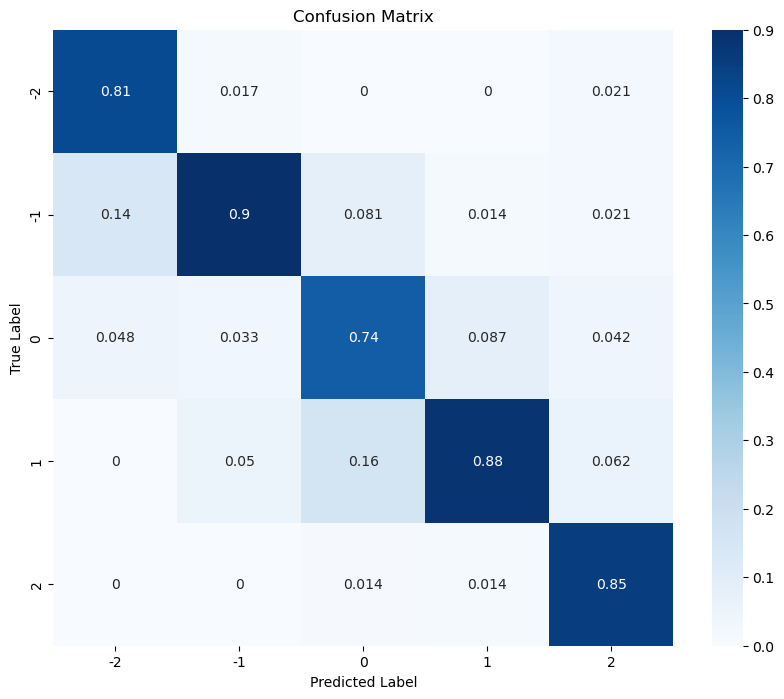

-1
-1
-1
2
-1
1
0
0
-1
2


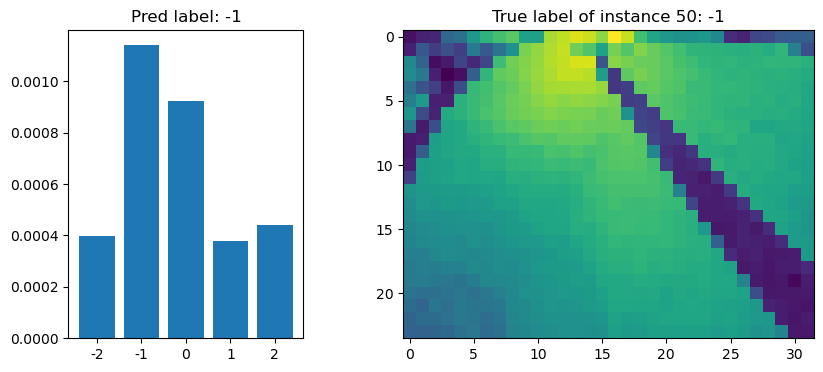

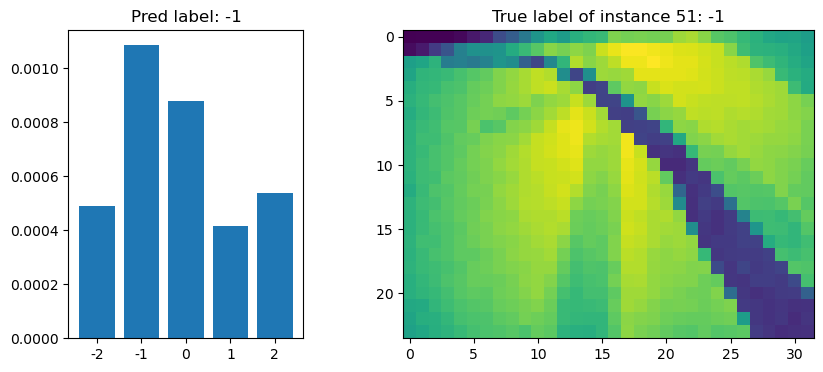

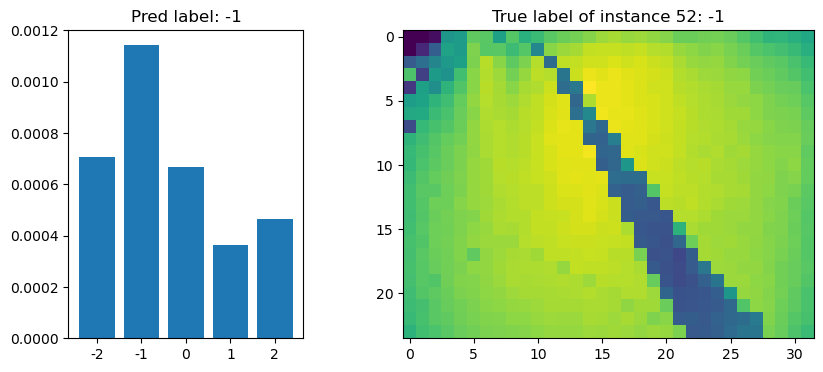

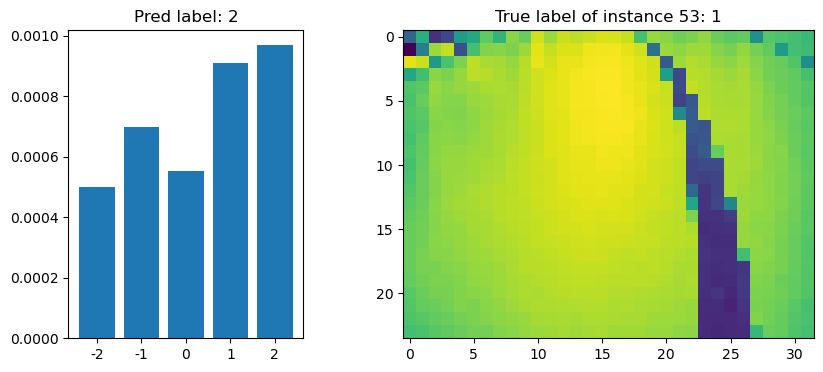

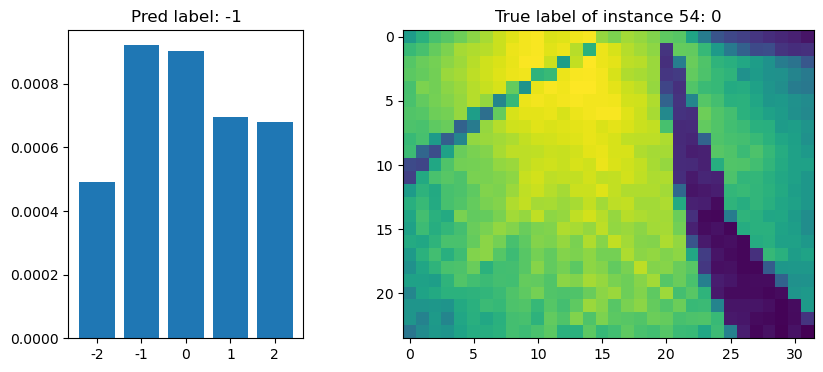

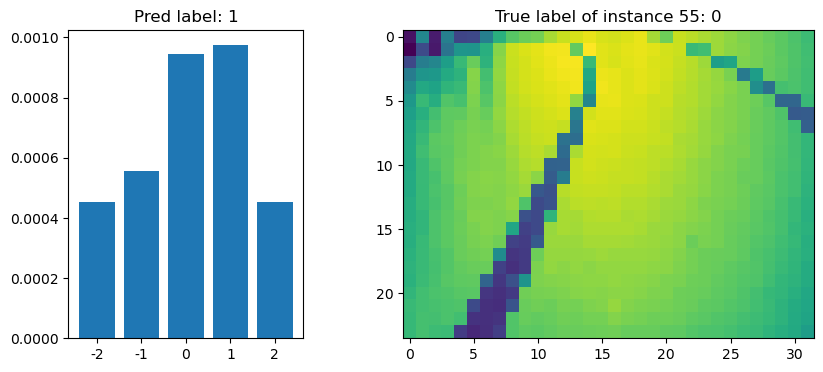

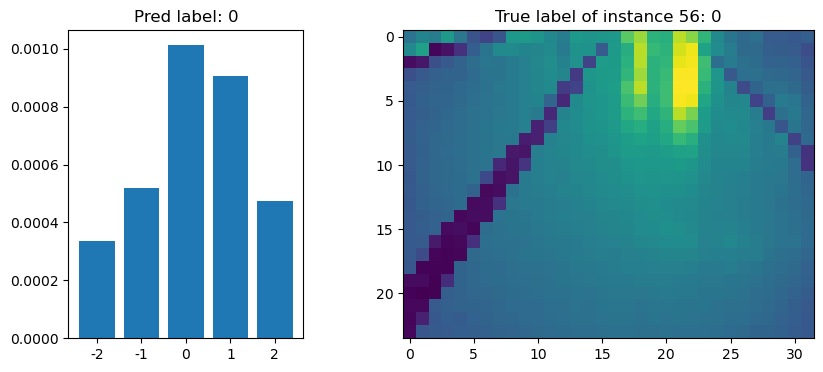

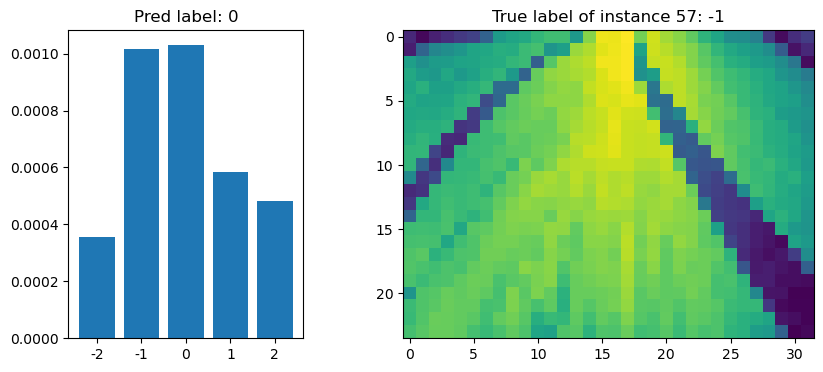

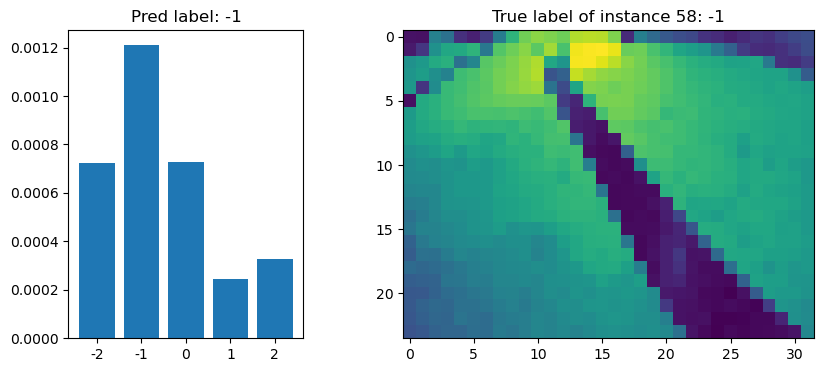

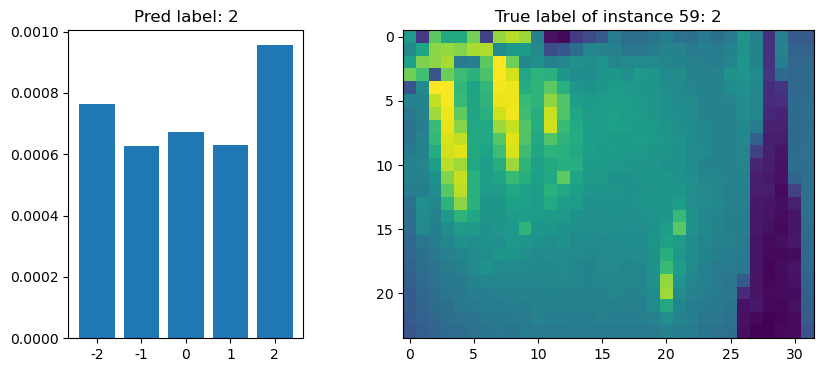

In [30]:
conf_matrix = confusion_matrix(y_test_tf, y_pred_tf, normalize='pred')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', 
            xticklabels=[str(deg) for deg in unique_degrees],
            yticklabels=[str(deg) for deg in unique_degrees])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# investigate probability distribution
def normal(data):
    shifted_data = data - np.min(data) + 1e-8
    prob_dist = shifted_data / np.sum(shifted_data)
    return prob_dist


for instance in range(50,60):
    y_prob = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch)  
            y_prob.extend(outputs.cpu().numpy())
    y_prob = np.array(y_prob)
    y_prob = normal(y_prob)

    class_list = np.array(list(class_folders.values()))
    pred_label = class_list[np.argmax(y_prob, axis=1)][instance]
    print(pred_label)

    fig, axs = plt.subplots(1,2, figsize=(10,4), gridspec_kw={'width_ratios': [1, 2]})
    axs[0].bar([str(deg) for deg in unique_degrees], y_prob[instance])
    axs[0].set_title("Pred label: {}".format(pred_label))

    true_label = int(np.dot(y_test[instance], class_list))

    axs[1].imshow(X_test[instance].squeeze(0))
    axs[1].set_title("True label of instance {}: {}".format(instance, true_label))

